In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [3]:
ds=xr.open_dataset('../postp/cesm2.gridann.1976.nc')

In [4]:
ix=(ds.TWS.var(dim='year').min(dim='ens')>0).compute()
la=ix*xr.open_dataset('mask_grnlnd_antarc.nc').landarea
nx=(la>0).sum().values
ix=la>0

In [5]:
nens=len(ds.ens)
mgs=[];m0s=[];m1s=[];m2s=[]
for ee in range(nens):
    if ee%5==0:
        print(ee)
    xa=detrend_dim(1e-9*(la*ds.TWS.isel(ens=ee)).sum(dim=['lat','lon']),'year')
    ya=detrend_dim(1e-9*(24*60*60*365*la*ds.NBP.isel(ens=ee)).sum(dim=['lat','lon']),'year')
    m,b,r,p,err=stats.linregress(xa,ya)
    mgs.append(m)

    twsa=detrend_dim(la*ds.TWS.isel(ens=ee),'year').values[ix,:]
    nbpa=detrend_dim(24*60*60*365*la*ds.NBP.isel(ens=ee),'year').values[ix,:]

    mvals=np.array([stats.linregress(x,y)[0] for x,y in zip(twsa,nbpa)])

    wts=(la/la.sum()).values[ix]
    m0=(wts*mvals).sum()
    x=twsa.var(axis=1)
    wts=x/x.sum()
    m1=(wts*mvals).sum()
    covxx=np.cov(twsa)
    m2=(covxx*mvals).sum()/covxx.sum()

    m0s.append(m0)
    m1s.append(m1)
    m2s.append(m2)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


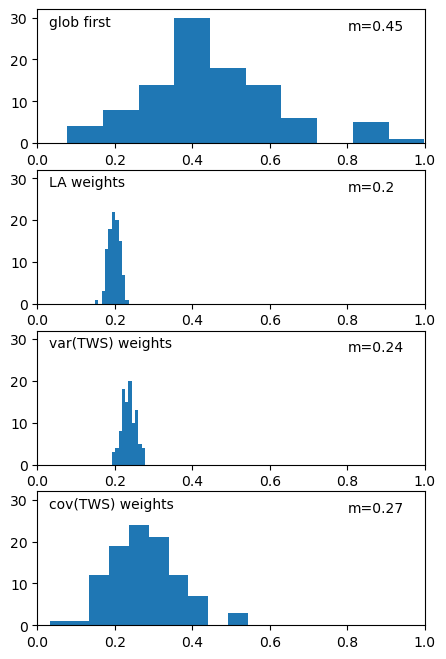

In [14]:
plt.figure(figsize=[5,8])
labs=['glob first','LA weights','var(TWS) weights','cov(TWS) weights']
for i,m in enumerate([mgs,m0s,m1s,m2s]):
    plt.subplot(4,1,i+1)
    plt.hist(m)
    plt.xlim([0,1])
    plt.ylim([0,32])
    plt.text(0.8,27,'m='+str(np.round(np.mean(m),2)))
    plt.text(0.03,28,labs[i])

In [54]:
las={}
las['cesm1']=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
las['cesm2']=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
las['mpige']=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
las['mpi12']=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea

In [55]:
cfs={}
cfs['cesm1']=1
cfs['cesm2']=1
cfs['mpige']=1000
cfs['mpi12']=1000

In [65]:
mglobs={};mgrids={}
for mdl in ['cesm1','cesm2','mpige','mpi12']:
    print(mdl)
    ds=xr.open_dataset('../postp/'+mdl+'.gridann.1976.nc')

    ix=(ds.SW.var(dim='year').min(dim='ens')>0).compute()
    la=ix*las[mdl]
    nx=(la>0).sum().values
    ix=la>0

    m1=[]
    m2=[]
    for ee in range(len(ds.ens)):
        xa=detrend_dim(1e-9*(la*ds.SW.isel(ens=ee)).sum(dim=['lat','lon']),'year')
        ya=cfs[mdl]*detrend_dim(1e-9*(24*60*60*365*la*ds.NBP.isel(ens=ee)).sum(dim=['lat','lon']),'year')
        m,b,r,p,err=stats.linregress(xa,ya)
        m1.append(m)


        xa=detrend_dim(la*ds.SW.isel(ens=ee),'year').values[ix,:]
        ya=cfs[mdl]*detrend_dim(24*60*60*365*la*ds.NBP.isel(ens=ee),'year').values[ix,:]

        mvals=np.array([stats.linregress(x,y)[0] for x,y in zip(xa,ya)])
        varx=xa.var(axis=1)
        m2.append((varx*mvals).sum()/varx.sum())


    mglobs[mdl]=m1
    mgrids[mdl]=m2

cesm1
cesm2
mpige
mpi12


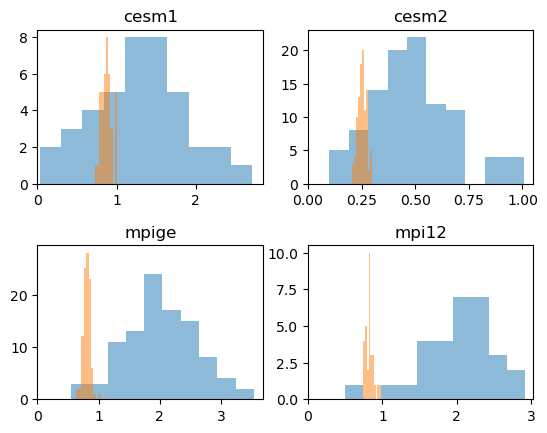

In [70]:
for i,mdl in enumerate(['cesm1','cesm2','mpige','mpi12']):
    plt.subplot(2,2,i+1)
    plt.hist(mglobs[mdl],alpha=0.5,)
    plt.hist(mgrids[mdl],alpha=0.5)
    plt.xlim(left=0)
    plt.title(mdl)
plt.subplots_adjust(hspace=0.4)

In [37]:
lats=np.tile(ds.lat.values.reshape([-1,1]),[1,288])[ix]

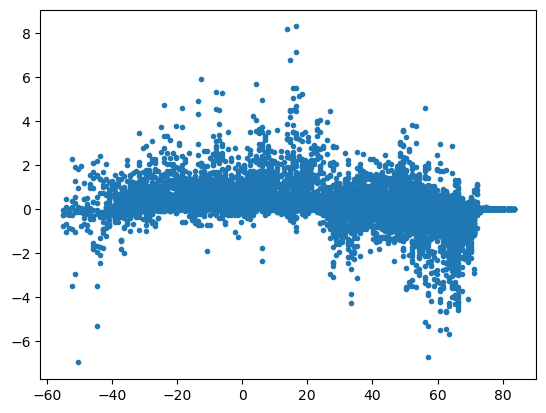

In [38]:
plt.plot(lats,mvals,'.')

In [130]:
m=np.zeros(100)
for ee in range(100):
    twsa=detrend_dim(la*ds.TWS.isel(ens=ee),'year').values[la>0,:]
    nbpa=detrend_dim(la*24*60*60*365*ds.NBP.isel(ens=ee),'year').values[la>0,:]
    covxx=np.cov(twsa)
    mvals=np.zeros([nx,1])+np.nan
    for i in range(nx):
        x=twsa[i,:]
        y=nbpa[i,:]
        mvals[i],b,r,p,err=stats.linregress(x,y)


    m[ee]=1/covxx.sum()*(covxx*mvals).sum()


In [134]:
xa=detrend_dim(1e-9*(la*ds.TWS).sum(dim=['lat','lon']),'year')
ya=detrend_dim(1e-9*24*60*60*365*(la*ds.NBP).sum(dim=['lat','lon']),'year')

In [139]:
mglob=np.zeros(100)
for ee in range(100):
    x=xa.sel(ens=ee)
    y=ya.sel(ens=ee)
    mglob[ee],b,r,p,err=stats.linregress(x,y)

In [142]:
stats.linregress(xa.values.ravel(),ya.values.ravel())

LinregressResult(slope=0.42186118610358736, intercept=9.286888407666875e-17, rvalue=0.5809385976354192, pvalue=4.1948914063228835e-136, stderr=0.01527143201032599, intercept_stderr=0.011168213448221408)

In [143]:
np.mean(m)

0.2723426062592149

(array([ 1.,  1., 12., 19., 24., 21., 12.,  7.,  0.,  3.]),
 array([0.03193086, 0.08297273, 0.1340146 , 0.18505648, 0.23609835,
        0.28714022, 0.33818209, 0.38922396, 0.44026584, 0.49130771,
        0.54234958]),
 <BarContainer object of 10 artists>)

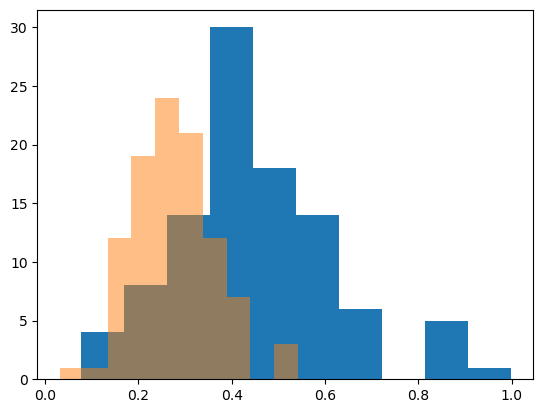

In [141]:
plt.hist(mglob)
plt.hist(m,alpha=0.5)

In [118]:
mvals.shape

(14233,)

In [110]:
1/covxx.sum()*(covxx*mvals).sum()

0.3013797760053688

In [ ]:
la.values

In [116]:
1/(la.values[la>0].sum())*(la.values[la>0]*mvals).sum()

0.2075709908763277

In [2]:
from utils import *

In [8]:
def preprocess(ds):
    dvs=[]
    yr0=ds['time.year'][0].values
    nt=len(ds.time)
    ds['time']=xr.cftime_range(str(yr0),periods=nt,freq='MS',calendar='noleap')
    if len(dvs)>0:
        ds=ds[dvs]
    return ds



In [17]:
f=lens_files('CESM2','TWS',yy=(1976,1990))[5]

In [20]:
ds=xr.open_mfdataset(f,combine='nested',concat_dim='time',preprocess=preprocess).sel(time=slice('1976','1990'))

In [55]:
tws=detrend_dim(amean(ds.TWS),'year').values

In [77]:
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
ix=(la>0)&(tws.std(axis=0)>0)

In [79]:
nx=ix.sum().values

In [80]:

jvals=np.tile(range(288),[192,1])[ix]

In [82]:
g=np.zeros(la.shape)+np.nan
g[ix]=np.random.randint(5,size=nx)

In [85]:
def calcr2(tws,g,ng):
    return np.sum([np.corrcoef(tws[:,g==i].T).sum() for i in range(ng)])

In [114]:
r2=calcr2(tws,g,ng)
for i in range(1000):
    g,r2=testswap(tws,g,ng,r2)
    if i%50==0:
        print(i,int(np.round(r2)))

0 521250
50 529754
100 538955
150 548479
200 556306
250 565057
300 577552
350 588501
400 598297
450 606667
500 613793
550 625069
600 635144
650 650164
700 662123
750 672948
800 685022
850 697728
900 709715
950 720380


In [106]:
def testswap(tws,g,ng,r2):
    x1=np.random.randint(nx)
    i1,j1=ivals[x1],jvals[x1]
    g1=g[i1,j1]

    rvals=[]
    for gg in range(ng):
        if gg==g1:
            rvals.append(r2)
        else:
            g[i1,j1]=gg
            rvals.append(calcr2(tws,g,ng))
    g[i1,j1]=np.argmax(rvals)
    
    
    return g,np.max(rvals)

In [102]:
rvals=np.random.randint(10,size=5)
rvals,np.argmax(rvals)

(array([1, 9, 1, 0, 0]), 1)

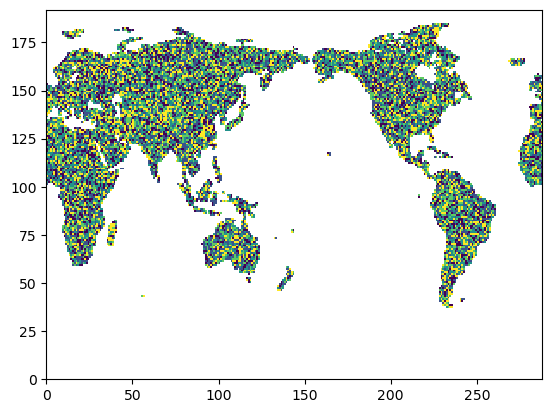

In [115]:
plt.pcolormesh(g)